# Predicción meteorológica por método Multivariante y Unistep

![Modelo](images/Diagrama_multivariable_unistep.png "Modelo multivariable y unistep")

Para este problema, utilizaremos el data set preprocesado que obtuvimos en [01_LSTM_weather_forecasting.Procesamiento_datos.ipynb](01_LSTM_weather_forecasting.Procesamiento_datos.ipynb).

Queremos pode predecir la variable temperatura en la próxima hora teniendo en cuenta todas las variables (14) en las 24 horas previas.

Supuestos:
- (1) De partida no consideraremos la variable datatime aunque si debemos mantener un índice.

## 0. Importamos librerías

In [1]:
# --- Bibliotecas estándar ---
import os
from datetime import datetime

# --- Bibliotecas de análisis de datos ---
import numpy as np
import pandas as pd

# --- Bibliotecas de visualización ---
import matplotlib.pyplot as plt

# --- Bibliotecas de aprendizaje automático ---
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# --- PyTorch y submódulos ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

# --- Módulos personalizados ---
import helpers.helpers as helpers

## 1. Cargamos los datos previamente procesados 📥 📂

In [2]:
# Ruta al archivo preprocesado
file_path = "data/max_planck_weather_ts_preprocesado.csv"

# Verificar existencia del archivo preprocesado
if os.path.exists(file_path):
    # Cargar el archivo si existe
    df = pd.read_csv(file_path)
    print("Archivo preprocesado cargado correctamente.")
else:
    # Mostrar mensaje de error si no se encuentra el archivo
    raise FileNotFoundError("El archivo preprocesado 'max_planck_weather_ts_preprocesado.csv' no se encuentra en la carpeta 'data'. Por favor, verifica su existencia o realiza el preprocesamiento necesario.")
    
# Mostrar el DataFrame cargado
df

Archivo preprocesado cargado correctamente.


,datetime,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,2016-12-31 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00
70124,2016-12-31 21:00:00,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50
70125,2016-12-31 22:00:00,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15
70126,2016-12-31 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70


In [3]:
df = df.drop(columns=['datetime'])
#df = df.reset_index()
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00
70124,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50
70125,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15
70126,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70


## 2.Feature Engineering

La Feature Engineering es el proceso de seleccionar, transformar y crear nuevas características (o "features") a partir de los datos brutos existentes para mejorar el rendimiento de los modelos de aprendizaje automático. En lugar de simplemente alimentar el modelo con los datos tal cual, la feature engineering busca aprovechar las relaciones entre las variables originales para obtener una representación más informativa y relevante para el problema que se está modelando.

Esto puede implicar:

- Limpieza y preprocesamiento: Manejar datos faltantes, corregir errores, eliminar valores atípicos, etc.

- Transformaciones matemáticas: Aplicar funciones como logaritmos, exponenciales, raíces cuadradas, normalización, estandarización, etc., para cambiar la distribución de los datos y hacerlos más adecuados para el modelo.

- Combinación de variables: Crear nuevas variables combinando dos o más variables existentes. Por ejemplo, crear una variable que sea la relación entre dos variables originales.

- Extracción de información: Derivar nuevas características a partir de variables existentes. Por ejemplo, si tienes una variable de fecha, puedes extraer el día de la semana, el mes, el año, etc.

- Selección de características: Identificar y seleccionar las características más relevantes para el modelo, descartando las que sean redundantes o irrelevantes.

El objetivo final es proporcionar al modelo características que le permitan aprender patrones de manera más eficiente y precisa, lo que se traduce en un mejor rendimiento del modelo en la tarea que se está realizando. En otras palabras, en lugar de depender del modelo para que descubra las relaciones importantes en los datos, la feature engineering ayuda al modelo a encontrar esas relaciones más fácilmente, preprocesando los datos y exponiendo la información de forma más clara.

En este ejemplo vamos a centrarnos en las variables relacionadas con el viento:
> wv (m/s): velocidad del viento (en m/s)
> wd (deg): dirección del viento (en grados)
> max. wv (m/s): velocidad del viento máxima (en m/s)

La velocidad máxima a priori NO tendría sentido si disponemos de la velocidad del viento. Además podremos componer velocidad y dirección del viento como un vector de dos componentes (Wx, Wy):
- Vx = wv * cos(wd)
- Vy = wv * sen(wd)

In [4]:
# Generamos nuestras nuevas variables Wx y Wy y las incluimos en el DataFrame
w_dir = df['wd (deg)']*np.pi/180
Wx = df['wv (m/s)']*np.cos(w_dir)
Wy = df['wv (m/s)']*np.sin(w_dir)
df['Wx'] = Wx
df['Wy'] = Wy

# Eliminamos las columnas innecesarias
df.pop('wd (deg)')
df.pop('wv (m/s)')
df.pop('max. wv (m/s)')

df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,-0.763420,-0.977133
70124,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,-0.541077,-0.281667
70125,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.376162,0.053871
70126,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,-0.643441,-0.614885


## 3. Pre-procesamiento
Dentro del pre-procesamiento de datos haremos:
1. Partición en train/val/test (80%, 10%, 10%)
2. Creación de las secuencias de datos
3. Normalización escalando los datos conforme a la variable/s

### 3.1. Partición del set en entrenamiento, validación y prueba

Como ya hicimos en los otros ejemplos, a diferencia de otros modelos de Machine Learning, en el caso de series de tiempo se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos.

Recordemos además para que se utiliza cada set de datos:
>Entrenamiento (train) se usará para encontrar los parámetros del modelo.
>
>Validación (val) se utiliza para verificar que no haya under/over-fitting del modelo y para ajustar sus hiperparámetros.
>
>Prueba/Evaluación (test) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación.

La diferencia con respecto a los casos univariados es que ahora NO pasaremos solo la variable a predecir, si no todo el data set con las variables elegidas.

In [5]:
from helpers import train_val_test_split

tr, vl, ts = train_val_test_split(df)
print(f'Tamaño data frame: {len(df)}')
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño data frame: 70128
Tamaño set de entrenamiento: (56102, 13)
Tamaño set de validación: (7012, 13)
Tamaño set de prueba: (7014, 13)


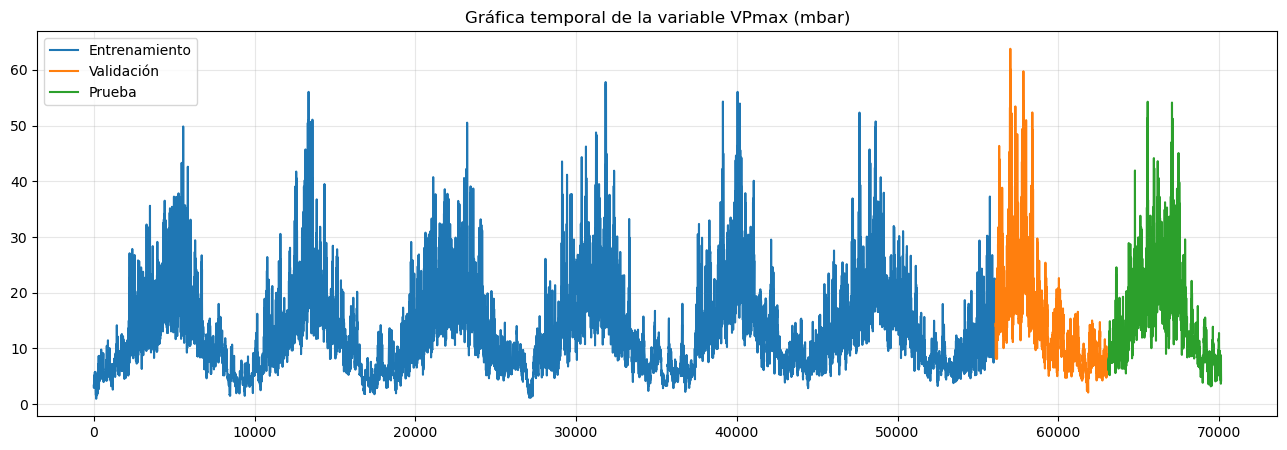

In [35]:
# Para dibujar la gráfica temporal, elegimos una variable y representamos
ind = 5     # Se corresponde con el ídice de la variable en el DataFrame
col = df.columns[ind]

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(tr[col], label='Entrenamiento')
ax.plot(vl[col], label='Validación')
ax.plot(ts[col], label='Prueba')
ax.set_title(f'Gráfica temporal de la variable {col}')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### 3.1 Creación de las secuencias de datos

El dato de entrada debe tener una dimensión (batches, longitud y variables).

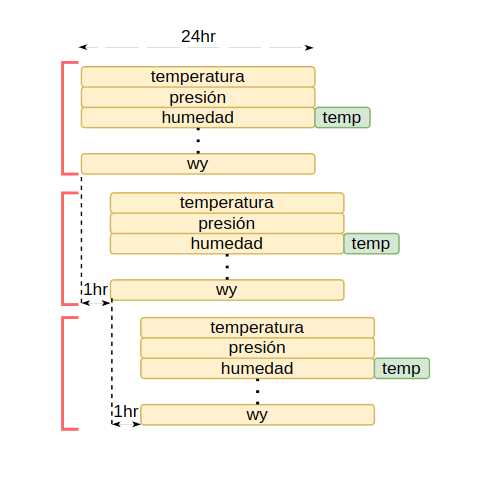

In [ ]:
from helpers import create_dataset_supervised

# Creamos los dataset de entrenamiento, prueba y validación
INPUT_LENGTH = 24       # Ventana de entrada de 24 horas previas
OUTPUT_LENGTH = 1       # Ventana de salida de 1 hora posterior
INPUT_FEACTURES = 13      # Número de variables que entrarán en el modelo
OUTPUT_FEACTURES = 1      # Número de variables que saldrán del modelo

OUTPUT_COLUMN_INDEX = df.columns.get_loc("T (degC)")

x_tr, y_tr = create_dataset_supervised(tr.values, INPUT_LENGTH, OUTPUT_LENGTH, OUTPUT_COLUMN_INDEX)
x_vl, y_vl = create_dataset_supervised(vl.values, INPUT_LENGTH, OUTPUT_LENGTH, OUTPUT_COLUMN_INDEX)
x_ts, y_ts = create_dataset_supervised(ts.values, INPUT_LENGTH, OUTPUT_LENGTH, OUTPUT_COLUMN_INDEX)

print('Tamaños de los conjuntos de datos (Seq x Input_length x Input_Features) y de salida (Seq x Input_length x Output_Features):')
print(f'Tamaño set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Tamaño set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Tamaño set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños de los conjuntos de datos (Seq x Input_length x Input_Features) y de salida (Seq x Input_length x Output_Features):
Tamaño set de entrenamiento - x_tr: (56077, 24, 13), y_tr: (56077, 1, 1)
Tamaño set de validación - x_vl: (6987, 24, 13), y_vl: (6987, 1, 1)
Tamaño set de prueba - x_ts: (6989, 24, 13), y_ts: (6989, 1, 1)


### 3.3 Normalización escalando los datos conforme a la variable/s
 
 Adiferencia de los ejemplos univariados, tenemos que normalizar todas y cada una de nuestras variables. Generando un escalador por cada una de las variables.
 
 Además deberemos recuperar el escalador para nuestra variable a predecir (Temperatura).

In [11]:
from helpers import scale_data

# Escalamos los datos
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts
}

# Escogemos la columna de referencia para el escalado
col_ref = df.columns.get_loc("T (degC)")

data_s, scaler = scale_data(data_in)

# Extraemos los datos escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

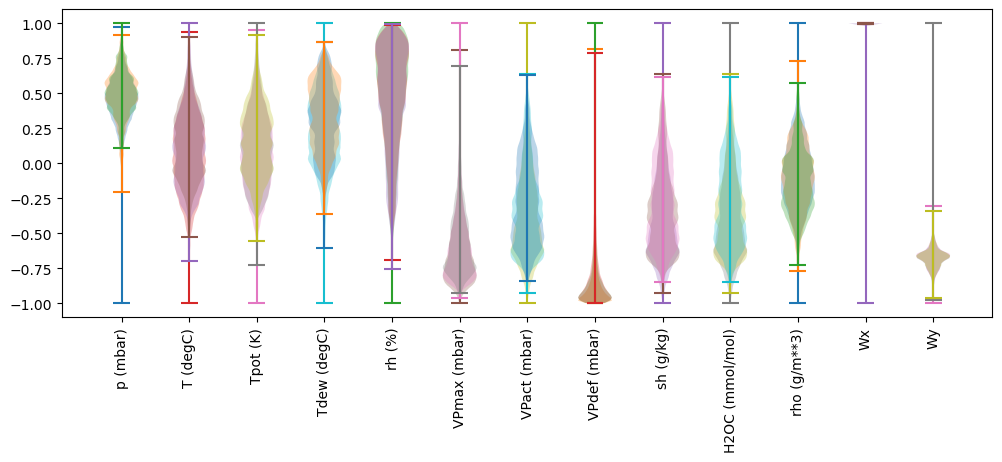

In [8]:
# Y generemos una gráfica tipo violín para ver la distribución de las distintas variables
# de entrada
fig, ax = plt.subplots(figsize=(12,4))
for i in range(13):
  ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
  ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
  ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(13)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

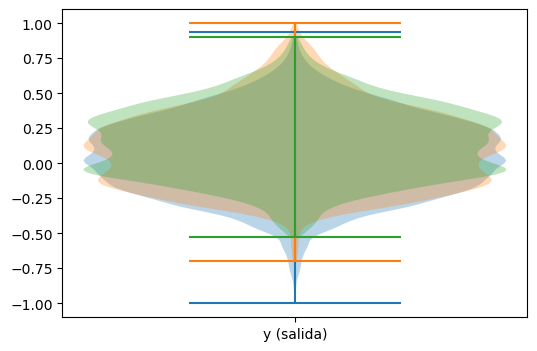

In [9]:
# y lo mismo para la variable de salida
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

**Nota**: Cada color en cada gráfica violín representa los datos de entrenamiento, validación y prueba.

## 4. Creación del modelo

In [2]:
# Definir modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out.unsqueeze(1)  # Añadir dimensión para que sea (batch_size, 1, output_dim)


## 5. HIPERPARÁMETROS Y DATALOADERS

In [3]:
# Ajustar parámetros para reproducibilidad
torch.manual_seed(123)
np.random.seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)

# Hiperparámetros del modelo
BATCH_SIZE = 64
LEARNING_RATE = 0.01
INPUT_DIM = 13       # Número de características (1 para univariado)
HIDDEN_DIM = 128    # Dimensión de la capa oculta
OUTPUT_DIM = 1      # Dimensión de salida (1 para predicción de un paso)
NUM_LAYERS = 1      # Número de capas LSTM

# Preparación Dataset
# Convertir datos a tensores de PyTorch
x_tr_tensor = torch.FloatTensor(x_tr_s)
y_tr_tensor = torch.FloatTensor(y_tr_s)
x_vl_tensor = torch.FloatTensor(x_vl_s)
y_vl_tensor = torch.FloatTensor(y_vl_s)
x_ts_tensor = torch.FloatTensor(x_ts_s)
y_ts_tensor = torch.FloatTensor(y_ts_s)

# Crear Dataset
train_dataset = TensorDataset(x_tr_tensor, y_tr_tensor)
val_dataset = TensorDataset(x_vl_tensor, y_vl_tensor)
test_dataset = TensorDataset(x_ts_tensor, y_ts_tensor)

# Crear DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear el modelo
model = LSTMModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)
model.to(device)

LSTMModel(
  (lstm): LSTM(13, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## 6. DEFINICIÓN OPTIMIZADOR

In [4]:
# Optimizador
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

## 7. ENTRENAMIENTO

In [5]:
from helpers import root_mean_squared_error
from helpers import r_squared
from helpers import accuracy_threshold
import os

# Entrenamiento
EPOCHS = 100

# Inicializar TensorBoard writer
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
archivo_registro = f"LSTM_multivariable_unistep"
log_dir = f"runs/{archivo_registro}_Adam_scheduler_LR_{LEARNING_RATE}_({EPOCHS}epch)_{timestamp}"
writer = SummaryWriter(log_dir)

# Mostrar estructura del modelo en TensorBoard
sample_input = torch.randn(1, 24, INPUT_DIM).to(device)  # (batch_size, seq_length, input_dim)
writer.add_graph(model, sample_input)

history = {'train_loss': [], 'val_loss': [], 
           'train_r2': [], 'val_r2': [], 
           'train_acc': [], 'val_acc': []}

# Variable para seguimiento de cambios en la tasa de aprendizaje
prev_lr = optimizer.param_groups[0]['lr']

for epoch in range(EPOCHS):
    # Modo entrenamiento
    model.train()
    train_loss = 0.0
    train_r2_total = 0.0
    train_acc_total = 0.0
    batch_count = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Borrar gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calcular pérdida
        loss = root_mean_squared_error(outputs, targets)
        
        # Calcular R² y accuracy por umbral
        r2 = r_squared(outputs, targets)
        acc = accuracy_threshold(outputs, targets, threshold=0.1)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_r2_total += r2
        train_acc_total += acc
        batch_count += 1
    
    # Calcular pérdida promedio de entrenamiento
    train_loss /= len(train_loader)
    train_r2 = train_r2_total / batch_count
    train_acc = train_acc_total / batch_count
    
    # Guardar en history
    history['train_loss'].append(train_loss)
    history['train_r2'].append(train_r2)
    history['train_acc'].append(train_acc)
    
    # Registrar en TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_r2, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
    # Modo evaluación
    model.eval()
    val_loss = 0.0
    val_r2_total = 0.0
    val_acc_total = 0.0
    batch_count = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calcular pérdida
            loss = root_mean_squared_error(outputs, targets)
            
            # Calcular R² y accuracy por umbral
            r2 = r_squared(outputs, targets)
            acc = accuracy_threshold(outputs, targets, threshold=0.1)
            
            val_loss += loss.item()
            val_r2_total += r2
            val_acc_total += acc
            batch_count += 1
    
    # Calcular pérdida promedio de validación
    val_loss /= len(val_loader)
    val_r2 = val_r2_total / batch_count
    val_acc = val_acc_total / batch_count
    
    # Actualizar el scheduler con la pérdida de validación
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    if epoch > 0 and current_lr != prev_lr:
        print(f"Época {epoch+1}: Tasa de aprendizaje reducida a {current_lr}")
    prev_lr = current_lr
    
    # Guardar en history
    history['val_loss'].append(val_loss)
    history['val_r2'].append(val_r2)
    history['val_acc'].append(val_acc)
    
    # Registrar en TensorBoard
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("R2/val", val_r2, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    writer.add_scalar("Learning_Rate", optimizer.param_groups[0]['lr'], epoch)
    
    # Si es una época específica, visualizar algunas predicciones
    if (epoch + 1) % 20 == 0:
        # Obtener algunos datos de validación
        inputs, targets = next(iter(val_loader))
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Obtener predicciones
        model.eval()
        with torch.no_grad():
            predictions = model(inputs)
        
        # Crear gráfica de predicciones vs valores reales
        fig, ax = plt.subplots(figsize=(10, 5))
        # Convertir a CPU para trabajar con matplotlib
        predictions = predictions.cpu().numpy()
        targets = targets.cpu().numpy()
        
        # Graficar primeras 10 muestras
        x = np.arange(10)
        ax.plot(x, targets[:10, 0, 0], 'bo-', label='Real')
        ax.plot(x, predictions[:10, 0, 0], 'ro-', label='Predicción')
        ax.set_title(f'Predicciones vs Valores Reales - Época {epoch+1}')
        ax.legend()
        
        # Añadir a TensorBoard
        writer.add_figure("Predictions", fig, epoch)
    
    # Imprimir progreso cada 10 épocas o al final
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == EPOCHS - 1:
        print(f'Época {epoch+1}/{EPOCHS}, '
              f'Pérdida Train/Val: {train_loss:.4f}/{val_loss:.4f}, '
              f'R² Train/Val: {train_r2:.4f}/{val_r2:.4f}, '
              f'Acc Train/Val: {train_acc:.2%}/{val_acc:.2%}')

# Actualizar hiperparámetros en TensorBoard
writer.add_hparams(
    {"hidden_dim": HIDDEN_DIM, "num_layers": NUM_LAYERS, "batch_size": BATCH_SIZE, "lr": LEARNING_RATE},
    {"final_train_loss": history['train_loss'][-1], "final_val_loss": history['val_loss'][-1]}
)

# Graficar la curva de pérdida
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history['train_loss'], label='Entrenamiento')
ax.plot(history['val_loss'], label='Validación')
ax.set_xlabel('Época')
ax.set_ylabel('RMSE')
ax.set_title('Curva de Pérdida')
ax.legend()
writer.add_figure("Learning Curve", fig)

# Registrar parámetros en un archivo de texto
experiment_file = os.path.join(log_dir, f"{archivo_registro}.txt")
with open(experiment_file, 'w') as f:
    f.write(f"Experimento: {archivo_registro}\n")    
    f.write(f"Fecha: {timestamp}\n")    
    
    f.write("\nHiperparámetros:\n")
    f.write(f"- Input Dim: {INPUT_DIM}\n")
    f.write(f"- Hidden Dim: {HIDDEN_DIM}\n")
    f.write(f"- Num Layers: {NUM_LAYERS}\n")
    f.write(f"- Batch Size: {BATCH_SIZE}\n")
    f.write(f"- Learning Rate: {LEARNING_RATE}\n")
    f.write(f"- Epochs: {EPOCHS}\n\n")
    
    f.write("Resultados finales:\n")
    f.write(f"- Train Loss (RMSE): {history['train_loss'][-1]:.4f}\n")
    f.write(f"- Validation Loss (RMSE): {history['val_loss'][-1]:.4f}\n")
    f.write(f"- Train R²: {history['train_r2'][-1]:.4f}\n")
    f.write(f"- Validation R²: {history['val_r2'][-1]:.4f}\n")
    f.write(f"- Train Accuracy: {history['train_acc'][-1]:.2%}\n")
    f.write(f"- Validation Accuracy: {history['val_acc'][-1]:.2%}\n\n")
    
    # Información sobre el mejor valor de validación
    best_epoch = np.argmin(history['val_loss'])
    f.write("Mejor modelo (menor pérdida de validación):\n")
    f.write(f"- Época: {best_epoch + 1}\n")
    f.write(f"- Validation Loss (RMSE): {history['val_loss'][best_epoch]:.4f}\n")
    f.write(f"- Validation R²: {history['val_r2'][best_epoch]:.4f}\n")
    f.write(f"- Validation Accuracy: {history['val_acc'][best_epoch]:.2%}\n")

# Cerrar el writer
writer.close()

# Puedes imprimir la ruta para referencia
print(f"Registros de TensorBoard guardados en: {log_dir}")
print(f"Registro de parámetros guardado en: {experiment_file}")

Época 1/100, Pérdida Train/Val: 0.0300/0.0308, R² Train/Val: 0.9815/0.8878, Acc Train/Val: 98.53%/99.13%
Época 10: Tasa de aprendizaje reducida a 0.005
Época 10/100, Pérdida Train/Val: 0.0241/0.0265, R² Train/Val: 0.9921/0.9028, Acc Train/Val: 99.51%/99.46%
Época 16: Tasa de aprendizaje reducida a 0.0025
Época 20/100, Pérdida Train/Val: 0.0228/0.0230, R² Train/Val: 0.9928/0.9306, Acc Train/Val: 99.52%/99.50%
Época 30/100, Pérdida Train/Val: 0.0226/0.0229, R² Train/Val: 0.9930/0.9314, Acc Train/Val: 99.55%/99.55%
Época 40/100, Pérdida Train/Val: 0.0224/0.0221, R² Train/Val: 0.9931/0.9380, Acc Train/Val: 99.56%/99.52%
Época 46: Tasa de aprendizaje reducida a 0.00125
Época 50/100, Pérdida Train/Val: 0.0219/0.0228, R² Train/Val: 0.9934/0.9312, Acc Train/Val: 99.59%/99.45%
Época 53: Tasa de aprendizaje reducida a 0.000625
Época 59: Tasa de aprendizaje reducida a 0.0003125
Época 60/100, Pérdida Train/Val: 0.0215/0.0223, R² Train/Val: 0.9937/0.9370, Acc Train/Val: 99.61%/99.52%
Época 70/100, 

📈 Iniciar TensorBoard. Posiciónate en tu consola en la ruta raiz y ejecuta:

tensorboard --logdir=runs

Esto abrirá un servidor en el http://localhost:600x/ que se indique en consola.

## 8. DESEMPEÑO DEL MODELO
Será óptima si el RMSE de los tres set de datos es equivalente.

In [7]:
def eval_rmse_in_batches(model, x, y, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    x = x.to(device)
    y = y.to(device)
    mse_loss = nn.MSELoss()
    total_mse = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for i in range(0, len(x), batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # Predicción del modelo
            pred = model(x_batch)
            
            # Ajustar dimensiones si no coinciden
            if pred.shape != y_batch.shape:
                pred = pred.permute(0, 2, 1)
            
            # Calcular la pérdida
            mse = mse_loss(pred, y_batch)
            total_mse += mse.item() * len(x_batch)
            total_samples += len(x_batch)
    
    rmse = torch.sqrt(torch.tensor(total_mse / total_samples))
    return rmse.item()

# Usar la función para evaluar en batches
rmse_tr = eval_rmse_in_batches(model, x_tr_tensor, y_tr_tensor, batch_size=32)
rmse_vl = eval_rmse_in_batches(model, x_vl_tensor, y_vl_tensor, batch_size=32)
rmse_ts = eval_rmse_in_batches(model, x_ts_tensor, y_ts_tensor, batch_size=32)

print(f"RMSE Entrenamiento: {rmse_tr:.3f}")
print(f"RMSE Validación: {rmse_vl:.3f}")
print(f"RMSE Evaluación: {rmse_ts:.3f}")

RMSE Entrenamiento: 0.021
RMSE Validación: 0.023
RMSE Evaluación: 0.022


## 9. GUARDAMOS EL MODELO 💾

In [8]:
models_dir = 'models'

# Crear directorio models si no existe
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Generar nombre de archivo con fecha y hora
#timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
model_filename = f"{models_dir}/LSTM_multivariable_unistep_{timestamp}.pt"

# Guardar el checkpoint del modelo entrenado
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': history['train_loss'][-1],
    'val_loss': history['val_loss'][-1],
    'hyperparameters': {
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE
    },
    'input_dim': INPUT_DIM,
    'output_dim': OUTPUT_DIM
}, model_filename)

print(f"Modelo guardado en: {model_filename}")

Modelo guardado en: models/LSTM_multivariable_unistep_2025-04-01_23-21.pt


## 10. PREDICCIONES CON NUESTRO MODELO
Vamos a comparar todo nuestro set de datos con sus etiquetas.

![Captura desde 2025-04-01 20-44-18.png](<attachment:Captura desde 2025-04-01 20-44-18.png>)

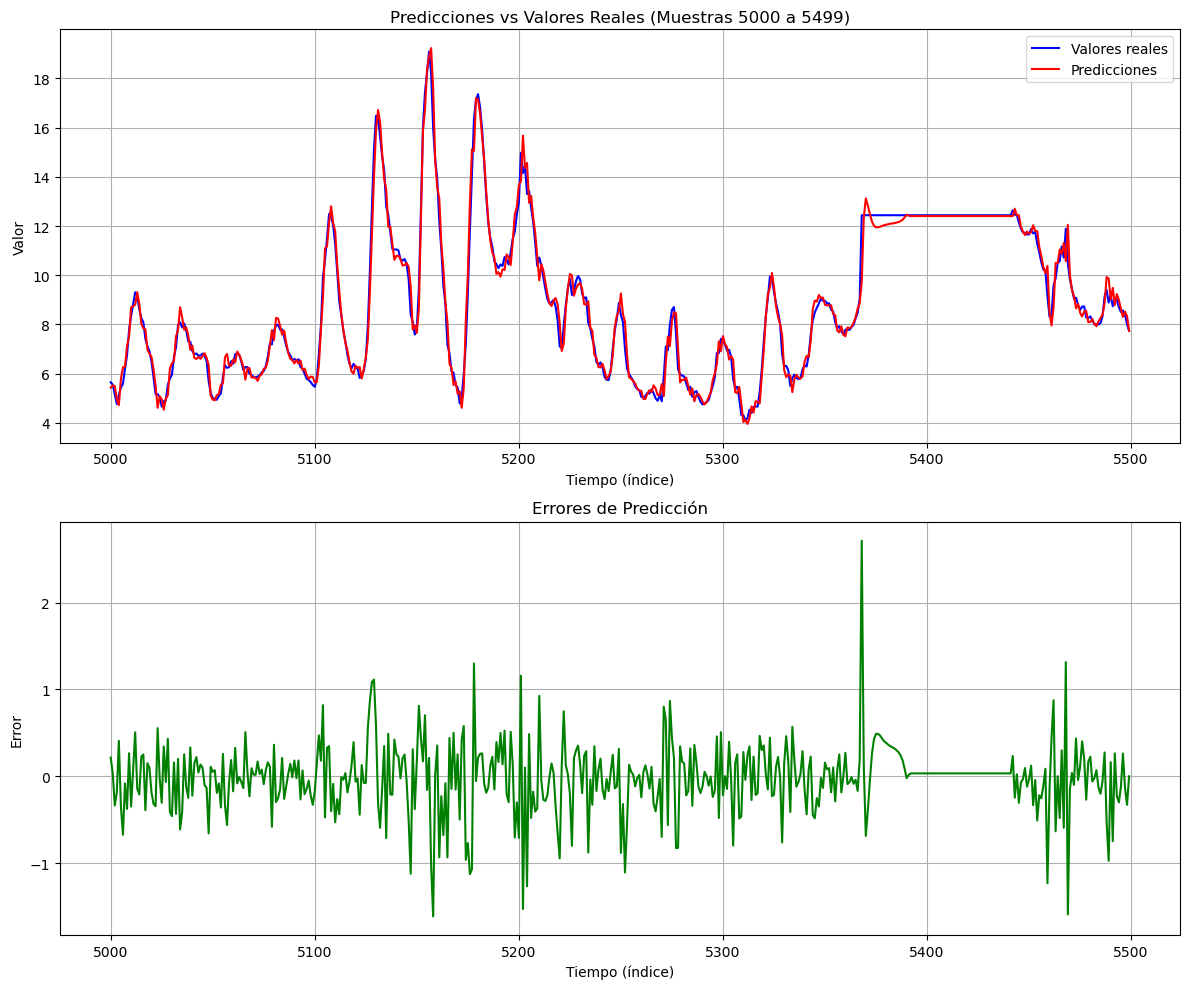

Estadísticas para el rango seleccionado (muestras 5000-5499):
Error medio: -0.0203
Error absoluto medio: 0.2785
Error cuadrático medio: 0.1637
RMSE: 0.4046


In [10]:
from helpers import predictions

# Calculo de las predicciones sobre el set de prueba
y_ts_pred = predictions(x_ts_s, model, scaler)

# Definir el rango de tiempo a visualizar (índices inicial y final)
tiempo_inicio = 5000  # Índice de inicio (cambia según necesites)
tiempo_fin = 5500    # Índice de fin (cambia según necesites)

# Asegurarse de que los índices estén dentro del rango válido
N = len(y_ts_pred)
tiempo_inicio = max(0, min(tiempo_inicio, N-1))
tiempo_fin = max(tiempo_inicio+1, min(tiempo_fin, N))

# Seleccionar solo los datos en el rango especificado
indices_seleccionados = slice(tiempo_inicio, tiempo_fin)
y_real_seleccionado = y_ts.flatten()[indices_seleccionados]
y_pred_seleccionado = y_ts_pred[indices_seleccionados]

# Crear el eje x (puedes personalizar este eje según tus datos)
# Por ejemplo, si tienes fechas reales, puedes usarlas aquí
eje_x = np.arange(tiempo_inicio, tiempo_fin)

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Valores reales vs predicciones
ax1.plot(eje_x, y_real_seleccionado, 'b-', label='Valores reales')
ax1.plot(eje_x, y_pred_seleccionado, 'r-', label='Predicciones')
ax1.set_title(f'Predicciones vs Valores Reales (Muestras {tiempo_inicio} a {tiempo_fin-1})')
ax1.set_xlabel('Tiempo (índice)')
ax1.set_ylabel('Valor')
ax1.legend()
ax1.grid(True)

# Cálculo de errores para el rango seleccionado
errores_seleccionados = y_real_seleccionado - y_pred_seleccionado

# Subplot 2: Errores
ax2.plot(eje_x, errores_seleccionados, 'g-')
ax2.set_title('Errores de Predicción')
ax2.set_xlabel('Tiempo (índice)')
ax2.set_ylabel('Error')
ax2.grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

# Calcular y mostrar estadísticas de error para el rango seleccionado
error_medio = np.mean(errores_seleccionados)
error_abs_medio = np.mean(np.abs(errores_seleccionados))
error_cuadratico_medio = np.mean(errores_seleccionados**2)
rmse = np.sqrt(error_cuadratico_medio)

print(f"Estadísticas para el rango seleccionado (muestras {tiempo_inicio}-{tiempo_fin-1}):")
print(f"Error medio: {error_medio:.4f}")
print(f"Error absoluto medio: {error_abs_medio:.4f}")
print(f"Error cuadrático medio: {error_cuadratico_medio:.4f}")
print(f"RMSE: {rmse:.4f}")

## 10. ANÁLISIS RESULTADOS
Con respecto a estos resultados:

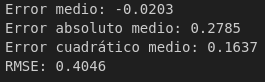

### Interpretación de las métricas de error

**Error medio: -0.0203°C**
- **¿Qué es?** Representa el promedio de las diferencias entre valores reales y predicciones.  
- **Interpretación** Un valor muy cercano a cero indica que el modelo no tiene un sesgo sistemático importante. En este caso, el valor ligeramente negativo sugiere que el modelo tiende a sobrestimar muy levemente los valores reales (predice temperaturas un poco más altas en promedio).  

---

**Error absoluto medio (MAE): 0.2785°C**
- **¿Qué es?** Es el promedio del valor absoluto de los errores.  
- **Interpretación** En promedio, nuestras predicciones de temperatura se desvían aproximadamente 0.28°C de los valores reales. Este valor es más bajo que el MAE del ejemplo anterior (0.3446°C), lo que indica que el modelo tiene un mejor rendimiento en términos de precisión general.  

---

**Error cuadrático medio (MSE): 0.1637°C²**
- **¿Qué es?** Es el promedio de los errores al cuadrado.  
- **Interpretación** Penaliza más severamente los errores grandes que los pequeños. El valor relativamente bajo del MSE sugiere que hay pocos errores grandes o extremos en las predicciones.  

---

**RMSE: 0.4046°C**
- **¿Qué es?** Es la raíz cuadrada del MSE, lo que devuelve el error a la escala original de los datos (grados Celsius).  
- **Interpretación** En promedio, nuestras predicciones tienen un error de aproximadamente 0.40°C. Este valor es más bajo que el RMSE del ejemplo anterior (0.4999°C), lo que indica que el modelo es más preciso en general.  

---

**Análisis globa **
- El error medio prácticamente nulo (-0.0203°C) indica que el modelo está bien balanceado, sin sesgos sistemáticos significativos.  
- La diferencia relativamente pequeña entre RMSE (0.4046°C) y MAE (0.2785°C) sugiere que la distribución de errores es bastante uniforme, sin muchos valores atípicos extremos.  
- En el contexto de predicción de temperatura, un RMSE de aproximadamente 0.40°C es considerado excelente, especialmente para predicciones a corto plazo.  
- El enfoque multivariado (usando múltiples variables como entrada) demuestra ser efectivo para capturar las relaciones complejas entre las variables meteorológicas que afectan a la temperatura.  
- Estas métricas sugieren que el modelo tiene un rendimiento muy bueno y sería útil para aplicaciones prácticas como sistemas de control de clima, gestión energética o pronósticos locales de corto plazo.  
